## Overview of AM Twitter Time Series Analysis

This script analyzes temporal trends in additive manufacturing (AM)-related tweets from 2012 to 2023. It integrates annual tweet counts, total engagement, 
and external estimates of Twitter's Monthly Active Users (MAU) to normalize activity metrics. Key outputs include:

- **Tweets per 1,000 MAU**, capturing normalized tweet volume
- **Engagement rate**, calculated as engagements per tweet
- **Engagements per 1,000 MAU**, providing normalized impact
- Visualizations with LOWESS smoothing and uncertainty bands
- A monthly engagement heatmap for seasonal insights

These analyses facilitate cross-year comparisons by accounting for platform growth and provide a robust basis for interpreting AM-related discourse trends over time.


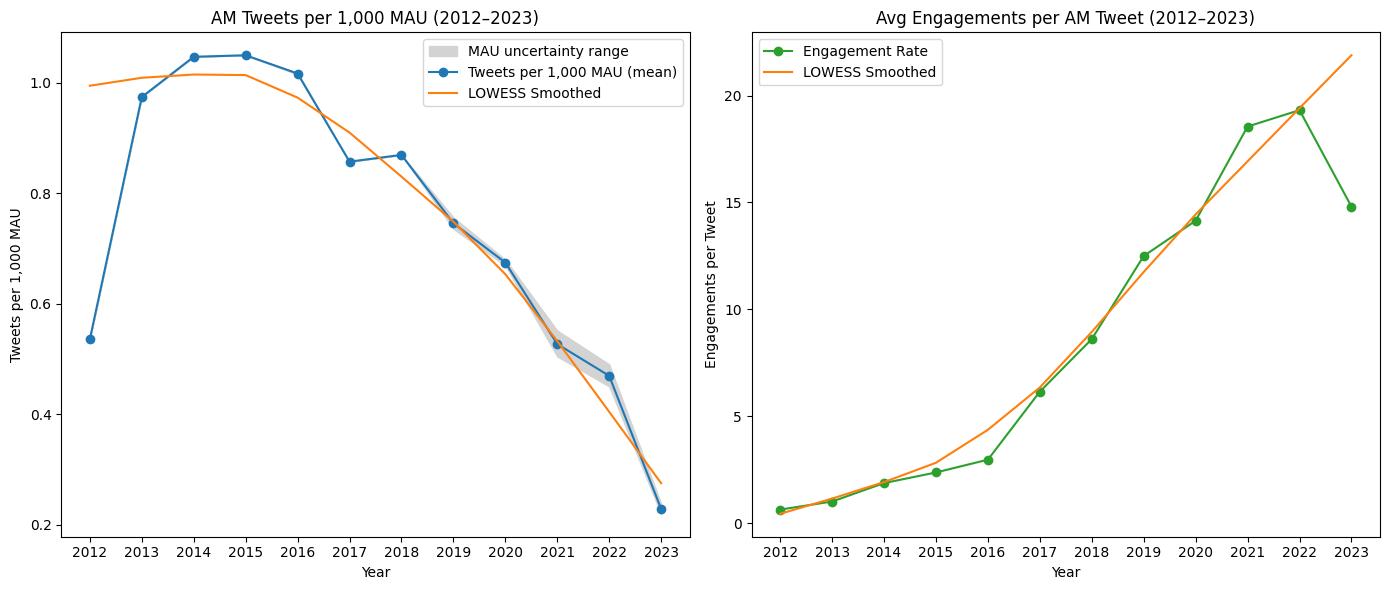

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime

# 1. Load the dataset
df = pd.read_csv('CLEANED_DATASET_20250531_004116.csv', parse_dates=['Date'])
df['Year'] = df['Date'].dt.year

# 2. Aggregate tweet counts and engagement per year
tweets_per_year = df.groupby('Year').size().rename('tweet_count').to_frame()
engagement_per_year = df.groupby('Year')['Total Engagement'].sum().rename('total_engagement').to_frame()

# 3. Monthly Active Users (MAU) estimates (in millions)
mau_estimates = {
    2012: [185],
    2013: [240.9],
    2014: [288],
    2015: [320],
    2016: [319, 318],
    2017: [330],
    2018: [321],
    2019: [330],
    2020: [353, 347.6],
    2021: [396, 362.4],
    2022: [401, 368.4],
    2023: [541.56, 500]
}

# 4. Convert MAU estimates to a DataFrame with min/mean/max
mau_df = pd.DataFrame([
    {
        'Year': year,
        'mau_mean': np.mean(vals) * 1e6,
        'mau_min': np.min(vals) * 1e6,
        'mau_max': np.max(vals) * 1e6
    }
    for year, vals in mau_estimates.items()
]).set_index('Year')

# 5. Merge all metrics into a single DataFrame
data = tweets_per_year.join(engagement_per_year).join(mau_df).sort_index()

# 6. Compute normalized metrics
data['tweets_per_1000_mau_mean'] = data['tweet_count'] / data['mau_mean'] * 1000
data['tweets_per_1000_mau_low']  = data['tweet_count'] / data['mau_max']  * 1000
data['tweets_per_1000_mau_high'] = data['tweet_count'] / data['mau_min']  * 1000
data['engagement_rate'] = data['total_engagement'] / data['tweet_count']

# 7. LOWESS smoothing
lowess_norm = lowess(data['tweets_per_1000_mau_mean'], data.index, frac=0.6)
lowess_eng  = lowess(data['engagement_rate'], data.index, frac=0.6)

# 8. Plot both charts side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharex=True)

# Left plot: Tweets per 1,000 MAU
axes[0].fill_between(data.index,
                     data['tweets_per_1000_mau_low'],
                     data['tweets_per_1000_mau_high'],
                     color='lightgray', label='MAU uncertainty range')
axes[0].plot(data.index, data['tweets_per_1000_mau_mean'], '-o', label='Tweets per 1,000 MAU (mean)')
#axes[0].plot(lowess_norm[:,0], lowess_norm[:,1], '-', label='LOWESS Smoothed')
axes[0].plot(lowess_norm[:,0], lowess_norm[:,1], '-', color='tab:orange', label='LOWESS Smoothed')
axes[0].set_title('AM Tweets per 1,000 MAU (2012–2023)')
axes[0].set_xlabel('Year')
axes[0].set_xticks(data.index)
axes[0].set_ylabel('Tweets per 1,000 MAU')
axes[0].legend()

axes[1].plot(data.index,
             data['engagement_rate'],
             '-o',
             color='tab:green',
             label='Engagement Rate')

axes[1].plot(lowess_eng[:,0],
             lowess_eng[:,1],
             '-',
             color='tab:orange',
             label='LOWESS Smoothed')

axes[1].set_title('Avg Engagements per AM Tweet (2012–2023)')
axes[1].set_xlabel('Year')
axes[0].set_xticks(data.index)
axes[1].set_ylabel('Engagements per Tweet')
axes[1].legend()

# Final layout adjustments and save
plt.tight_layout()
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f'./visualizations/ts_combined_timeseries_side_by_side_{ts}.png', dpi=300)
plt.show()


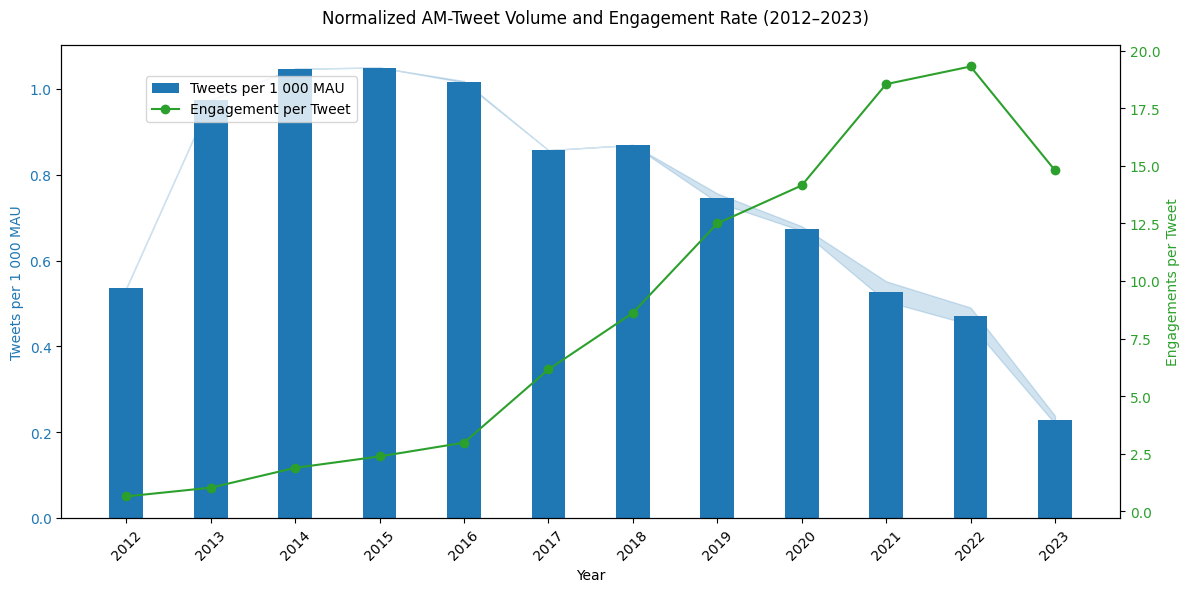

In [ ]:
# 7. LOWESS smoothing (optional)
lowess_norm = lowess(data['tweets_per_1000_mau_mean'], data.index, frac=0.6)
lowess_eng = lowess(data['engagement_rate'], data.index, frac=0.6)

# 8. Combined dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars for normalized tweet volume
ax1.bar(data.index,
        data['tweets_per_1000_mau_mean'],
        width=0.4,
        label='Tweets per 1 000 MAU',
        color='tab:blue')
# Uncertainty band
ax1.fill_between(data.index,
                 data['tweets_per_1000_mau_low'],
                 data['tweets_per_1000_mau_high'],
                 color='tab:blue',
                 alpha=0.2)

ax1.set_xlabel('Year')

# ✅ Force full x-axis ticks
years = data.index.tolist()
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)  # Optional rotation
ax1.set_ylabel('Tweets per 1 000 MAU', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary axis for engagement rate
ax2 = ax1.twinx()
ax2.plot(data.index,
         data['engagement_rate'],
         '-o',
         #color='tab:orange'
         color='tab:green',
         label='Engagement per Tweet')

ax2.set_ylabel('Engagements per Tweet', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Title and legend
fig.suptitle('Normalized AM-Tweet Volume and Engagement Rate (2012–2023)')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))

plt.tight_layout()

# Save with timestamp
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f'./visualizations/ts_combined_AM_volume_engagement.png', dpi=300, bbox_inches='tight')
plt.show()


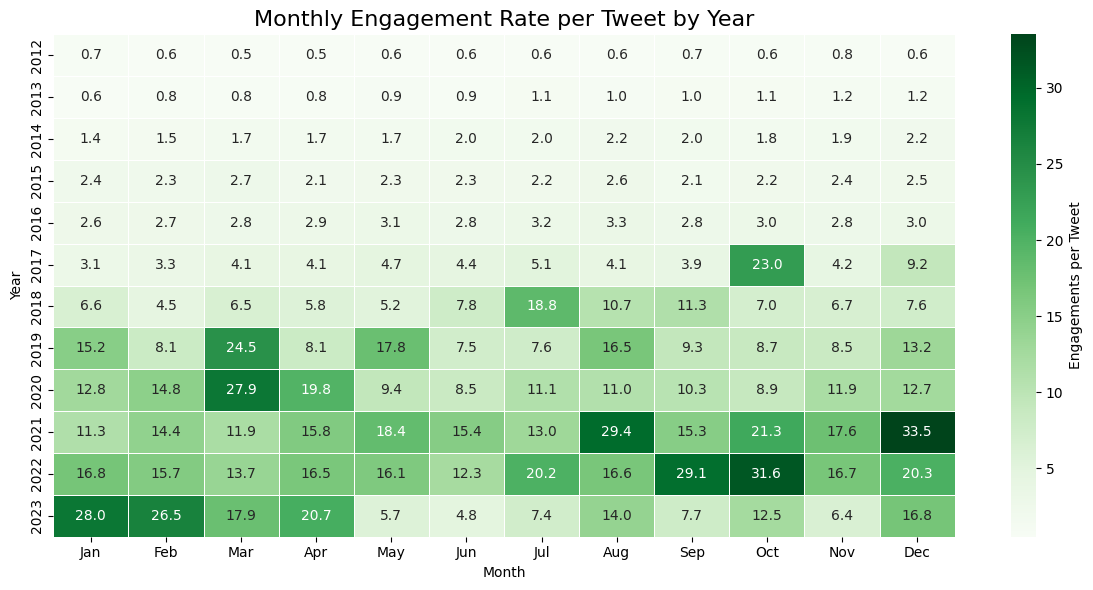

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ensure Date, Year, Month columns
df = pd.read_csv('CLEANED_DATASET_20250526_174217.csv', parse_dates=['Date'])
df['Year']  = df['Date'].dt.year
df['Month'] = df['Date'].dt.strftime('%b')  # 'Jan', 'Feb', ...

# 2. Define month order
month_order = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']

# 3. Compute monthly tweet counts and total engagement
monthly = (
    df
    .groupby(['Year','Month'])
    .agg(
        tweet_count       = ('Date','size'),
        total_engagement  = ('Total Engagement','sum')
    )
    .reset_index()
)

# 4. Compute engagement rate per month
monthly['engagement_rate'] = monthly['total_engagement'] / monthly['tweet_count']

# 5. Pivot into heatmap matrix
heatmap_data = (
    monthly
    .pivot(index='Year', columns='Month', values='engagement_rate')
    .reindex(columns=month_order)   # enforce calendar order
)

# 6. Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="Greens",
    linewidths=0.5,
    cbar_kws={'label': 'Engagements per Tweet'}
)
plt.title("Monthly Engagement Rate per Tweet by Year", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.savefig("./visualizations/ts_heatmap_monthly_engagement_rate.png", dpi=300)
plt.show()
